In [2]:
import itertools
import numpy as np
import pandas as pd
import proplot as pplt
import os
import pyproj
import sys
import warnings
import xarray as xr
# sys.path.append('/Users/dwatkin2/Documents/research/packages/buoy_processing/')
sys.path.append('../scripts/')
from scipy.interpolate import interp2d
from drifter import compute_velocity
from drifter import compute_along_across_components
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

#### Specify locations for data.
# External datasets not included in archive are stored in a lower 
# sic_loc = '../../../data/nsidc_daily_cdr/'
# motion_loc = '../../../data/nsidc_daily_icemotion/'
ift_loc = '../data/floe_tracker/ift_with_era5.csv'
df_ift = pd.read_csv(ift_loc, index_col=0)
df_ift.drop('Unnamed: 1', axis=1, inplace=True)
df_ift['datetime'] = pd.to_datetime(df_ift['datetime'].values)
sic = df_ift['sea_ice_concentration']
df_ift.loc[sic > 1, 'sea_ice_concentration'] = np.nan

# Additional filter
# I think I added this into the prep script
speed = np.sqrt(df_ift.loc[df_ift.qc_flag==0, 'u']**2 + df_ift.loc[df_ift.qc_flag==0, 'v']**2)
mean_u = df_ift.loc[df_ift.qc_flag==0, 'u'].mean()
mean_v = df_ift.loc[df_ift.qc_flag==0, 'v'].mean()

z = np.sqrt((df_ift.u - mean_u)**2 + (df_ift.v - mean_v)**2)/np.std(speed)
df_ift.loc[np.abs(z) > 6, 'qc_flag'] = 1
df_filtered = df_ift.loc[df_ift.qc_flag==0]

df_filtered['L'] = np.sqrt(df_filtered['area'])
df_filtered['l_bin'] = np.digitize(df_filtered['L'], bins=np.arange(0, 60, 5))
df_filtered['l_center'] = [pd.Series(np.arange(2.5, 63, 5), index=np.arange(1, 14))[x] for x in df_filtered['l_bin']]
subset = df_filtered.loc[(df_filtered.qc_flag == 0) & df_filtered.zeta.notnull()]

In [15]:
df_cyc = subset.where(subset.zeta > 0).dropna().pivot_table(
    columns='l_center', values='zeta', index='floe_id')
df_anticyc = -subset.where(subset.zeta < 0).dropna().pivot_table(
    columns='l_center', values='zeta', index='floe_id')

idx_cyc = df_cyc.notnull().sum(axis=0) > 100
idx_anticyc = df_anticyc.notnull().sum(axis=0) > 100

df_cyc = df_cyc.loc[:, idx_cyc].copy()
df_anticyc = df_anticyc.loc[:, idx_anticyc].copy()

In [25]:
print(df_cyc.notnull().sum(axis=0))

l_center
2.5      577
7.5     3421
12.5    1115
17.5     375
22.5     131
dtype: int64


In [5]:
sim_rot = pd.read_csv('../data/simulation/rotation_rates.csv')
sim_rot.columns = [c.replace('km', '') for c in sim_rot.columns]
sr_melted = sim_rot.melt()
sr_melted['variable'] = sr_melted['variable'].astype(int)
sr_melted.columns = ['length_scale', 'rotation_rate']
sr_melted['L'] = np.sqrt(np.pi*(sr_melted['length_scale'])**2)

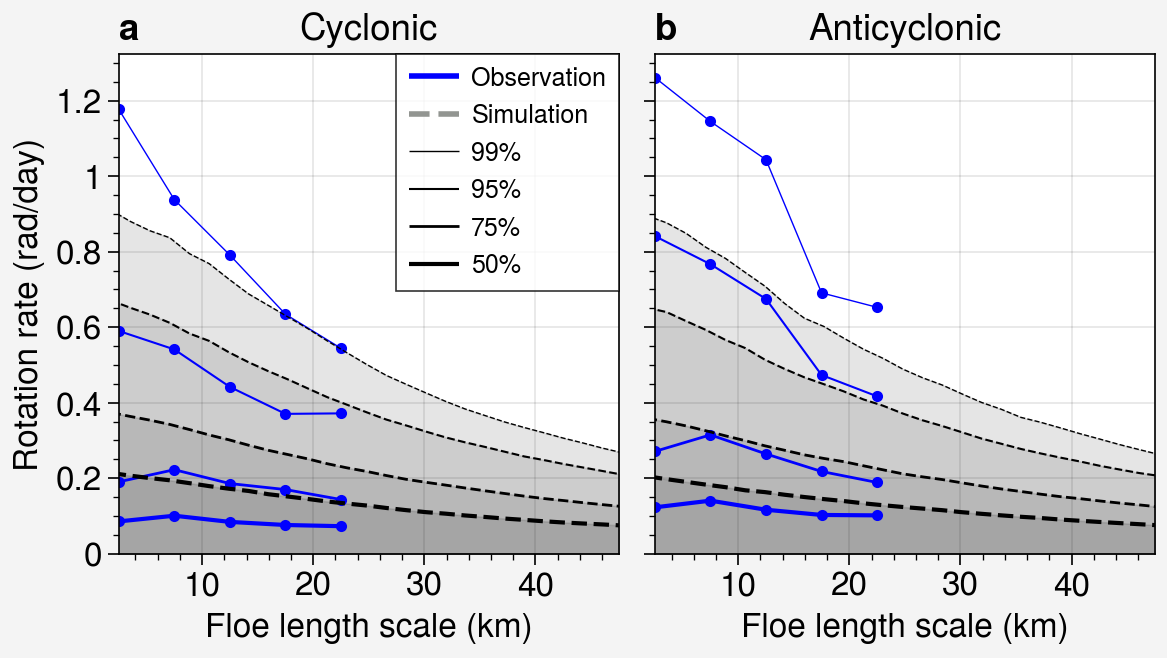

In [27]:
fig, axs = pplt.subplots(ncols=2, sharex=False)
R = sim_rot.where(sim_rot > 0).quantile(0.99, axis=0).interpolate().index.astype(int)
L = np.sqrt(np.pi)*R

for q, lw, m in zip([0.99, 0.95, 0.75, 0.5],
                        [0.5, 0.75, 1, 1.5],
                   ['', '', '', '']):
    

    axs[0].plot(df_cyc.columns, df_cyc.quantile(q, axis=0).interpolate(),
                color='b', lw=lw, marker='.', ls='-')
    axs[1].plot(df_anticyc.columns, df_anticyc.quantile(q, axis=0).interpolate(),
                color='b', lw=lw, ls='-', m='.')

    axs[0].plot(L, sim_rot.where(sim_rot > 0).quantile(q, axis=0).interpolate(),
                color='k', lw=lw, ls='--', marker=m)
    axs[0].area(L, sim_rot.where(sim_rot > 0).quantile(q, axis=0).interpolate(),
               alpha=0.1, color='k')

    
    axs[1].plot(L, (-sim_rot.where(sim_rot < 0)).quantile(q, axis=0).interpolate(),
                color='k', lw=lw, ls='--', marker=m)
    axs[1].area(L, (-sim_rot.where(sim_rot < 0)).quantile(q, axis=0).interpolate(),
               alpha=0.1, color='k')

axs[0].format(xlocator=np.arange(10, 51, 10),
          xlabel='Floe length scale (km)',
           ylabel='Rotation rate (rad/day)', xlim=(2.5, 47.5))
axs[1].format(xlocator=np.arange(10, 51, 10),
          xlabel='Floe length scale (km)',
           ylabel='Rotation rate (rad/day)', xlim=(2.5, 47.5))


axs[0].format(title='Cyclonic')
axs[1].format(title='Anticyclonic')
#     suptitle='Floe rotation rate distribution by length scale',)

# Legend
l = ['Observation', 'Simulation',
     '99%', '95%', '75%', '50%']
h = [axs[0].plot([],[],c=c, lw=lw, m='', ls=ls)
     for c, lw, ls in zip(['b', 'gray', 'k', 'k', 'k', 'k'],
                         [2, 2, 0.5, 0.75, 1, 1.5], ['-', '--', '-', '-', '-', '-'])]
axs[0].legend(h, l, ncols=1)
fig.format(fontsize=12, abc=True)
fig.save('../figures/fig05_rotation_rate_distribution.pdf', dpi=300)

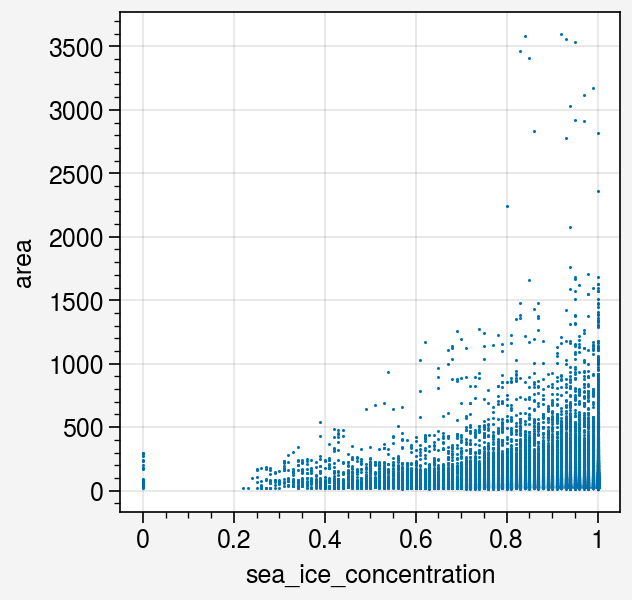

In [35]:
fig, ax = pplt.subplots()
ax.scatter(subset['sea_ice_concentration'], subset['area'], m='.', ms=1)